In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [24]:
import os
import pickle
import operator
import itertools
import tskit
import msprime
import numpy as np
import pyslim
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

In [164]:
force = True

## Load B Maps

In [165]:
#w_grid = np.array([1e-10, 3.16e-10, 1e-9, 3.16e-9, 1e-8, 3.16e-8])
#t_grid = np.array([0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1])

w_grid = np.logspace(-10, -8, 20)
t_grid = np.logspace(-5, -1, 20)

pkl_b_file = '../data/bmaps/bgspy/B_chr10_big.pkl'
step = 10_000

ncores = 70

In [167]:
if force or not os.path.exists(pkl_b_file):
    g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
    g.load_annot("../data/annotation/conserved_phastcons_thresh0_slop1k.bed")
    g.load_recmap("../data/annotation/HapMapII_GRCh37_liftedOverTo_Hg38/genetic_map_Hg38_chr10.txt")
    
    m = BGSModel(g, w_grid=w_grid, t_grid=t_grid, split_length=1_000)
    m.calc_Bp(N=1000, step=step, ncores=ncores, nchunks=200)
    m.calc_B(step=step, ncores=ncores, nchunks=70)
    m.save(pkl_b_file)
else:
    m = BGSModel.load(pkl_b_file)
    g = m.genome

FileNotFoundError: [Errno 2] No such file or directory: '../data/annotation/conserved_phastcons_thresh0_slop1k.bed'

In [87]:
bp = m.BpScores
b = m.BScores

## Likelihood Tests

In [148]:
ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed1006500984_rep67_treeseq.tree')
ts = ts.delete_sites([m.site for m in ts.mutations()])

In [149]:
ts = msprime.sim_mutations(ts, rate=1e-7, discrete_genome=True, model=msprime.BinaryMutationModel())

In [150]:
gd = GenomeData(g)
gd.load_counts_from_ts(ts=ts, chrom='chr10')

In [151]:
gd.counts

{'chr10': array([[2000.,    0.],
        [2000.,    0.],
        [2000.,    0.],
        ...,
        [2000.,    0.],
        [2000.,    0.],
        [2000.,    0.]])}

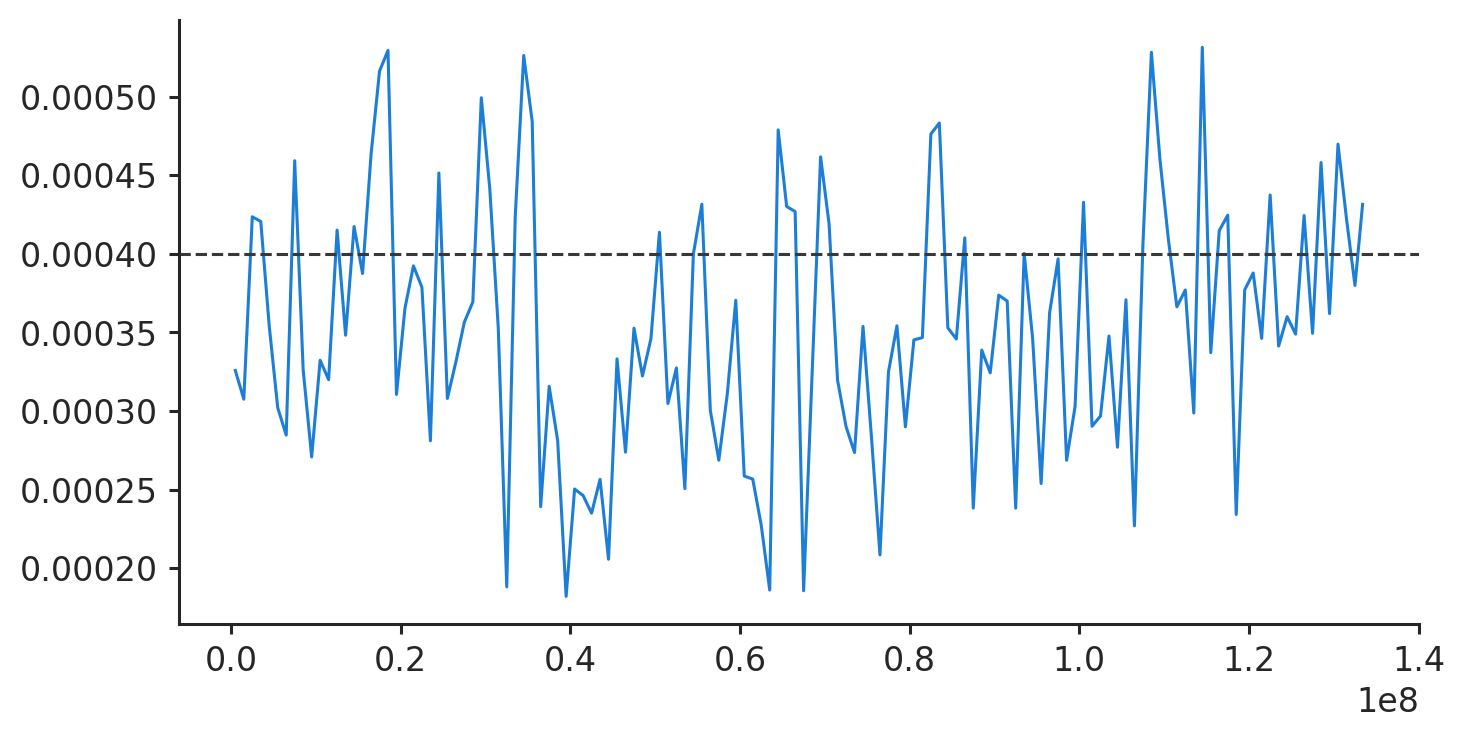

In [152]:
plt.plot(*gd.bin_pi(1e6)[1]['chr10'].pairs) 
N = 1000
mu = 1e-7
plt.axhline(4*N*mu, c='0.22', linestyle='dashed')

In [153]:
from itertools import product

def loglik(pi0, B, Y):
    pibar = pi0 * np.exp(B)
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    nw, nt = B.shape[1], B.shape[2]
    wi, ti = np.arange(nw), np.arange(nt)
    nf = B.shape[3]
    wt = list(product(wi, ti))
    xi = list(product(*[wt for _ in range(nf)]))
    comb_lls = np.zeros(len(xi))
    for i, row in enumerate(xi):
        for j, pair in enumerate(row):
            comb_lls[i] += lls[pair[0], pair[1], j]
    return comb_lls, xi

def loglik_interpol(pi0, B, Y, w):
    pibar = pi0 * np.exp(B)
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    # interpolate the dfe weights for each selcoef
    nf = lls.shape[2]
    nt = B.shape[2]
    interpols = [None] * nf
    for i in range(nf):
        interpols[i] = [None] * nt
        for j in range(nt):
            y = lls[:, j, i]
            assert(len(w) == len(y))
            interpols[i][j] = interpolate.interp1d(w, y, kind='quadratic', bounds_error=False, fill_value=-np.Inf)
            
    def ll_func(x):
        ll = 0
        x = x.reshape(nt, nf)
        for i in range(nf):
            for j in range(nt):
                # TODO fix for multiple features
                ll += interpols[i][j](x[j, i])
        return -ll
    return ll_func



def pred(pi0, B, ml_xi):
    Bc = np.array([B[:, wi, ti, i] for i, (wi, ti) in enumerate(ml_xi)])
    pibar = pi0 * np.exp(Bc.sum(axis=0))
    return pibar

In [154]:
# bin the genome data counts and do data reduction
bins, y = gd.bin_reduce(1e6)

# get the data out of the binnedstat (contains n too)
# note off-by-one
Y = y['chr10'].stat[1:, :]

In [155]:
# bin the Bs at the same level, using same bins
B = m.BScores.bin_means(bins, return_bins=True)['chr10'].stat

In [156]:
Y.shape, B.shape

((134, 2), (134, 6, 7, 1))

In [157]:
pi0s = np.logspace(-5, -1, 10)
lls = [np.max(loglik(pi0, B, Y)[0]) for pi0 in pi0s]

0.0005994842503189409


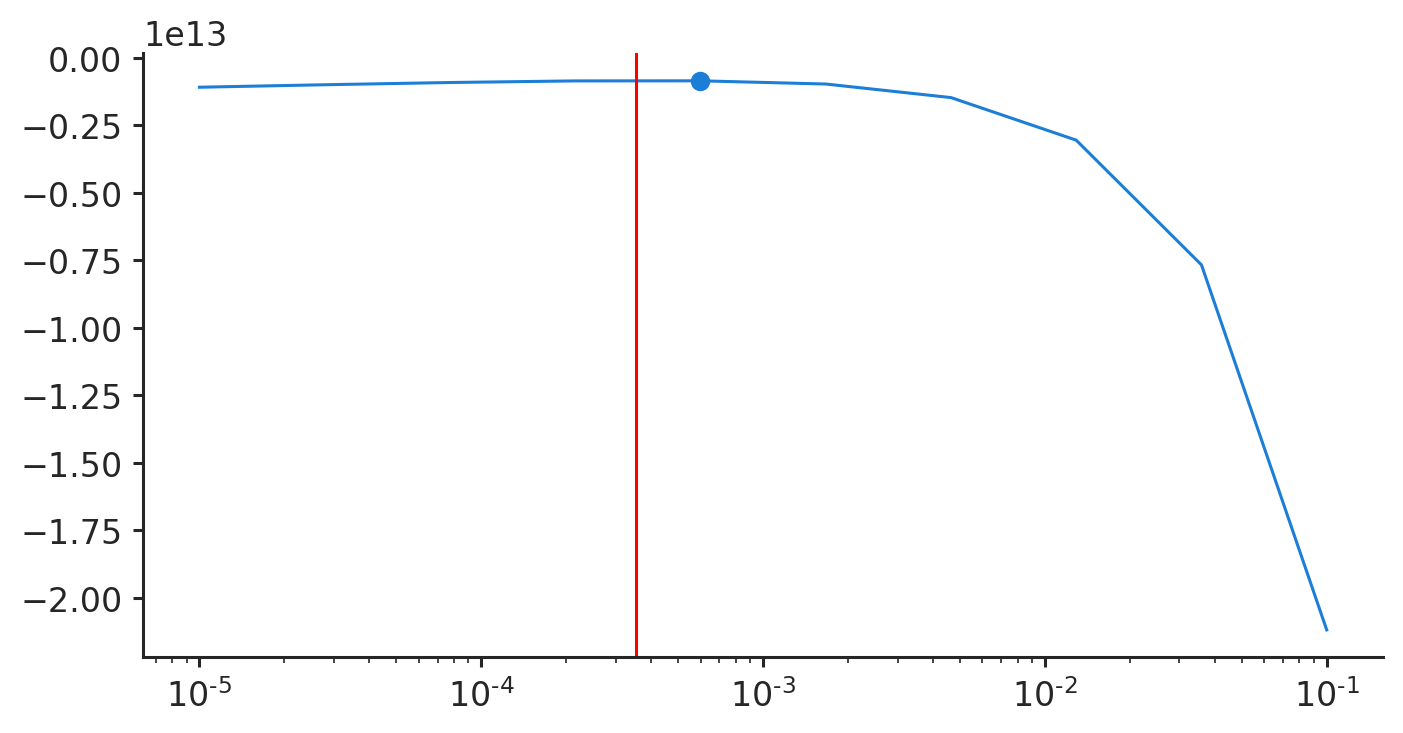

In [158]:
plt.plot(pi0s, lls)
plt.semilogx()
plt.scatter(pi0s[np.argmax(lls)], np.max(lls))
plt.axvline(gwpi, c='r')

mle_pi0 = pi0s[np.argmax(lls)]
print(mle_pi0)

In [146]:
def loglik_alt(pi0, B, y):
    # y is nsame, ndiff as cols
    # TODO does pi0 matter?
    assert(np.all(pi0 <= 0.5))
    pi = np.exp(np.add.outer(np.log(pi0), B))
    assert(np.all(pi <= 0.5))
    pi[pi==0] = np.nextafter(0, 1)
    #return y
    a = np.log(pi)*y[None, :, 1, None, None, None]
    b = np.log1p(-pi)*y[None, :, 0, None, None, None]
    assert(np.all(np.isfinite(a) | np.isnan(a)))
    assert(np.all(np.isfinite(b) | np.isnan(b)))
    ll = a + b
    #__import__('pdb').set_trace()
    return ll

loglik_alt(mle_pi0, B, Y)

FloatingPointError: underflow encountered in nextafter

In [147]:
debug

> /tmp/ipykernel_15234/2195709474.py(7)loglik_alt()
      5     pi = np.exp(np.add.outer(np.log(pi0), B))
      6     assert(np.all(pi <= 0.5))
----> 7     pi[pi==0] = np.nextafter(0, 1)
      8     #return y
      9     a = np.log(pi)*y[None, :, 1, None, None, None]



ipdb>  pi


array([[[[0.00059894],
         [0.00059909],
         [0.00059923],
         ...,
         [0.0005994 ],
         [0.00059943],
         [0.00059944]],

        [[0.00059775],
         [0.00059823],
         [0.00059867],
         ...,
         [0.00059922],
         [0.00059931],
         [0.00059933]],

        [[0.00059401],
         [0.00059552],
         [0.00059692],
         ...,
         [0.00059863],
         [0.00059894],
         [0.000599  ]],

        [[0.00058237],
         [0.00058706],
         [0.00059141],
         ...,
         [0.0005968 ],
         [0.00059775],
         [0.00059795]],

        [[0.00054698],
         [0.00056104],
         [0.00057431],
         ...,
         [0.00059105],
         [0.00059402],
         [0.00059464]],

        [[0.00044874],
         [0.00048621],
         [0.00052347],
         ...,
         [0.00057322],
         [0.00058237],
         [0.00058431]]],


       [[[0.00059929],
         [0.00059934],
         [0.00059937],
     

ipdb>  exit


In [139]:
a, b = loglik(mle_pi0, B, Y)

In [144]:
wi, ti = b[np.argmax(a)][0]
m.w[wi], m.t[ti]

(3.16e-08, 0.000316)

TypeError: Invalid shape (42,) for image data

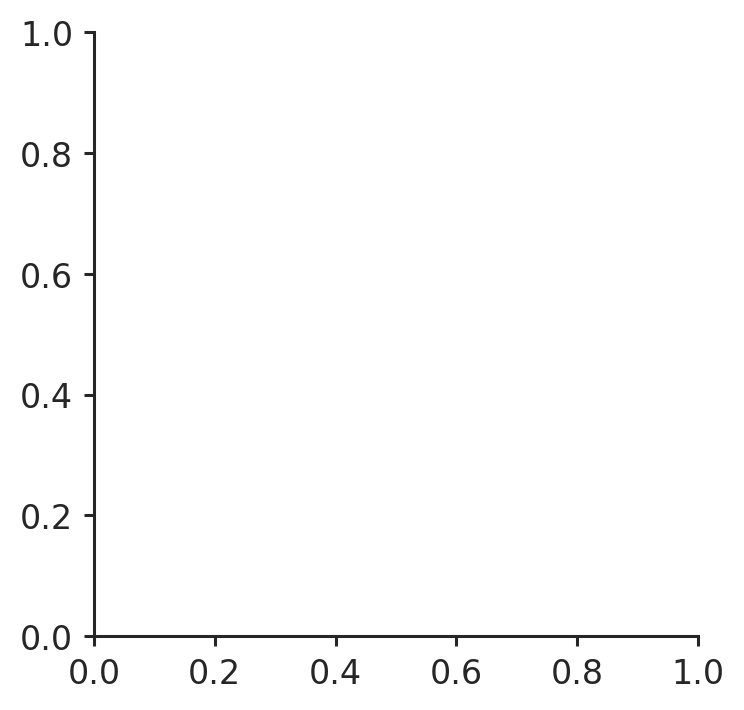

In [145]:
plt.imshow(a)